[View in Colaboratory](https://colab.research.google.com/github/dxftctcdtc/CodingPractice/blob/master/start_with_tensorflow.ipynb)

In [0]:
from __future__ import print_function 
import math
from IPython import display

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import gridspec 

import numpy as np
import pandas as pd
from sklearn import metrics


import tensorflow as tf
from tensorflow.python.data import Dataset
%matplotlib inline

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [0]:
chd = pd.read_csv("https://dl.google.com/mlcc/mledu-datasets/california_housing_train.csv", sep=",")

In [3]:
chd = chd.reindex(np.random.permutation(chd.index))
chd['median_house_value'] /= 1000.0
chd

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
825,-117.1,32.8,38.0,1130.0,228.0,699.0,241.0,2.6,167.6
4084,-118.0,34.1,33.0,1353.0,228.0,1079.0,237.0,4.5,160.3
2271,-117.4,33.9,26.0,2420.0,532.0,1383.0,469.0,3.5,113.5
5546,-118.2,34.0,33.0,346.0,103.0,488.0,107.0,1.9,112.5
11968,-121.4,38.6,36.0,1249.0,159.0,362.0,143.0,6.8,446.4
...,...,...,...,...,...,...,...,...,...
16072,-122.5,37.8,36.0,1997.0,356.0,772.0,348.0,5.0,322.6
14054,-122.0,37.5,23.0,4247.0,835.0,2357.0,823.0,5.1,211.3
8694,-118.6,34.1,23.0,9657.0,1189.0,3585.0,1162.0,10.4,500.0
7241,-118.3,34.3,37.0,1776.0,301.0,702.0,265.0,5.3,314.9


In [4]:
chd.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


In [0]:
# input features: total_rooms
my_feature = chd[['total_rooms']]
#configure a numeric feature column
feature_columns = [tf.feature_column.numeric_column("total_rooms")]

In [0]:
targets = chd['median_house_value']

In [0]:
#configure the LR
# use gradient descent as the optimizer for training the model
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# configure the LR model
linear_regressor = tf.estimator.LinearRegressor(feature_columns=feature_columns, optimizer=my_optimizer)

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
  features = {key:np.array(value) for key,value in dict(features).items()}
  
  ds = Dataset.from_tensor_slices((features, targets))
  ds = ds.batch(batch_size).repeat(num_epochs)
  
  if shuffle:
    ds = ds.shuffle(buffer_size=10000)
    
  features, labels = ds.make_one_shot_iterator().get_next()
  return features, labels

In [0]:
_ = linear_regressor.train(
    input_fn = lambda:my_input_fn(my_feature, targets),
    steps=100
)

In [10]:
prediction_input_fn = lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)
predictions = linear_regressor.predict(input_fn=prediction_input_fn)
predictions = np.array([item['predictions'][0] for item in predictions])

mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

Mean Squared Error (on training data): 55846.894
Root Mean Squared Error (on training data): 236.319


In [11]:
min_house_value = chd["median_house_value"].min()
max_house_value = chd["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Difference between Min. and Max.: %0.3f" % min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.002
Root Mean Squared Error: 236.319


In [12]:
calibration_data = pd.DataFrame()
calibration_data['predictions'] = pd.Series(predictions)
calibration_data['targets'] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,1.3,207.3
std,1.1,116.0
min,0.0,15.0
25%,0.7,119.4
50%,1.1,180.4
75%,1.6,265.0
max,19.0,500.0


In [0]:
sample = chd.sample(n=300)

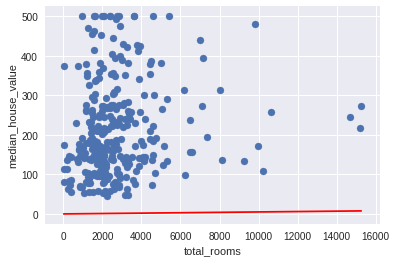

In [14]:
x_0 = sample['total_rooms'].min()
x_1 = sample['total_rooms'].max()

weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

y_0 = weight * x_0 + bias
y_1 = weight * x_1 + bias

plt.plot([x_0, x_1], [y_0, y_1], c='r')

plt.ylabel('median_house_value')
plt.xlabel('total_rooms')

plt.scatter(sample['total_rooms'], sample['median_house_value'])
plt.show()

In [0]:
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = chd[[my_feature]]
  my_label = "median_house_value"
  targets = chd[my_label]

  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  # Create input functions.
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = chd.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

Training model...
RMSE (on training data):
  period 00 : 225.63
  period 01 : 214.42
  period 02 : 204.04
  period 03 : 194.62
  period 04 : 186.29
  period 05 : 180.53
  period 06 : 175.66
  period 07 : 173.57
  period 08 : 170.91
  period 09 : 168.84
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,108.4,207.3
std,89.4,116.0
min,0.1,15.0
25%,59.9,119.4
50%,87.2,180.4
75%,129.2,265.0
max,1555.4,500.0


Final RMSE (on training data): 168.84


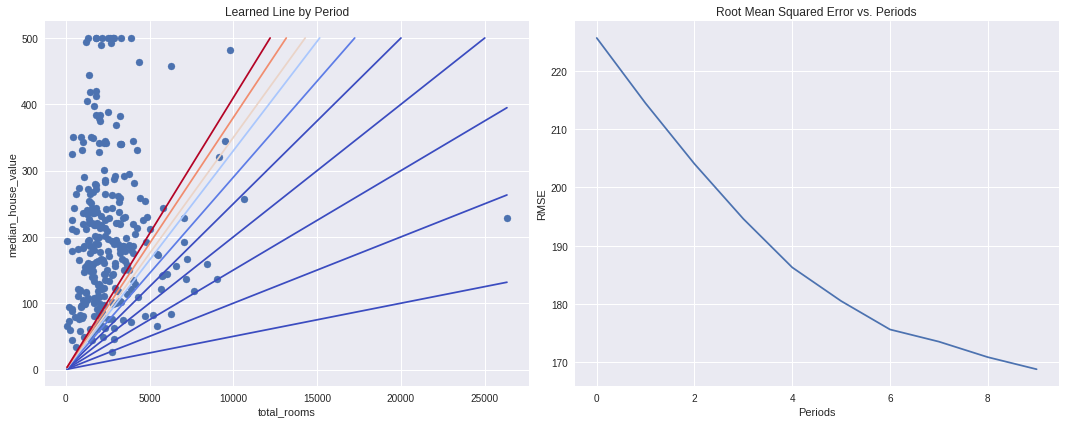

In [21]:
train_model(
  learning_rate=0.0001,
  steps=100,
  batch_size=1
)

Training model...
RMSE (on training data):
  period 00 : 225.63
  period 01 : 214.62
  period 02 : 204.67
  period 03 : 195.94
  period 04 : 188.98
  period 05 : 184.24
  period 06 : 180.26
  period 07 : 178.08
  period 08 : 176.70
  period 09 : 175.99
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,120.3,207.3
std,96.6,116.0
min,0.3,15.0
25%,66.5,119.4
50%,98.2,180.4
75%,144.9,265.0
max,3003.5,500.0


Final RMSE (on training data): 175.99


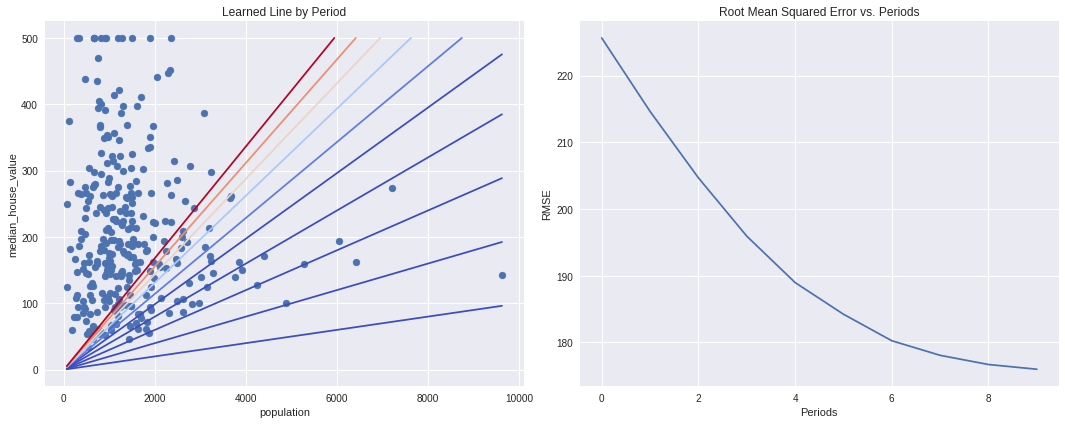

In [23]:
train_model(
    learning_rate=0.00002,
    steps=1000,
    batch_size=5,
    input_feature="population"
)